# DEEP LEARNING IN COMPUTER VISION

---

## Requirements

The experiments should use images found on the Internet:
- 5 images of **content** presenting: views of nature, urban buildings, people or animals, objects, plants;
- 3 images of **style** painted by different artists, e.g.: *Claude Monet, Vincent van Gogh, Paul Cézanne, Pablo Picasso, Salvador Dalí, Edvard Munch, Henri Matisse*.

## Importing libraries

In [ ]:
import os, numpy as np, warnings, matplotlib.pyplot as plt, tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.applications.vgg19 import *
warnings.filterwarnings('ignore')
tf.config.experimental_run_functions_eagerly(True)

## Setting the working directory

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Colab Notebooks/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## The StyleTransferrer class

In [ ]:
class StyleTransferrer(object):
    def __init__(self,
                 content_layers=None,
                 style_layers=None):
        self.model = VGG19(weights='imagenet',
                           include_top=False)
        self.model.trainable = False
        self.style_weight = 1e-2
        self.content_weight = 1e4
        if content_layers is None:
            self.content_layers = ['block5_conv2']
        else:
            self.content_layers = content_layers
        if style_layers is None:
            self.style_layers = ['block1_conv1',
                                 'block2_conv1',
                                 'block3_conv1',
                                 'block4_conv1',
                                 'block5_conv1']
        else:
            self.style_layers = style_layers
        outputs = [self.model.get_layer(name).output
                   for name in
                   (self.style_layers + self.content_layers)]
        self.style_model = Model([self.model.input], outputs)

    def _gram_matrix(self, input_tensor):
        result = tf.linalg.einsum('bijc,bijd->bcd',
                                  input_tensor,
                                  input_tensor)
        input_shape = tf.shape(input_tensor)
        num_locations = np.prod(input_shape[1:3])
        num_locations = tf.cast(num_locations, tf.float32)
        result = result / num_locations
        return result

    def _calc_outputs(self, inputs):
        inputs = inputs * 255
        preprocessed_input = preprocess_input(inputs)
        outputs = self.style_model(preprocessed_input)
        style_outputs = outputs[:len(self.style_layers)]
        content_outputs = outputs[len(self.style_layers):]
        style_outputs = [self._gram_matrix(style_output)
                         for style_output in style_outputs]
        content_dict = {content_name: value
                        for (content_name, value)
                        in zip(self.content_layers,
                               content_outputs)}
        style_dict = {style_name: value
                      for (style_name, value)
                      in zip(self.style_layers,
                             style_outputs)}
        return {'content': content_dict,
                'style': style_dict}

    @staticmethod
    def _clip_0_1(image):
        return tf.clip_by_value(image,
                                clip_value_min=0.0,
                                clip_value_max=1.0)

    @staticmethod
    def _compute_loss(outputs, targets):
        return tf.add_n([
            tf.reduce_mean((outputs[key] - targets[key]) ** 2)
            for key in outputs.keys()
        ])

    def _calc_total_loss(self,
                         outputs,
                         style_targets,
                         content_targets):
        style_outputs = outputs['style']
        content_outputs = outputs['content']
        # Style loss
        n_style_layers = len(self.style_layers)
        s_loss = self._compute_loss(style_outputs,
                                    style_targets)
        s_loss *= self.style_weight / n_style_layers
        # Content loss
        n_content_layers = len(self.content_layers)
        c_loss = self._compute_loss(content_outputs,
                                    content_targets)
        c_loss *= self.content_weight / n_content_layers
        # Total loss
        return s_loss + c_loss

    @tf.function()
    def _train(self,
               image,
               s_targets,
               c_targets,
               epochs,
               steps_per_epoch):
        optimizer = tf.optimizers.Adam(learning_rate=2e-2,
                                       beta_1=0.99,
                                       epsilon=0.1)
        for _ in range(epochs):
            for _ in range(steps_per_epoch):
                with tf.GradientTape() as tape:
                    outputs = self._calc_outputs(image)
                    loss = self._calc_total_loss(outputs,
                                                 s_targets,
                                                 c_targets)
                gradient = tape.gradient(loss, image)
                optimizer.apply_gradients([(gradient, image)])
                image.assign(self._clip_0_1(image))
        return image

    @staticmethod
    def _tensor_to_image(tensor):
        tensor = tensor * 255
        tensor = np.array(tensor, dtype=np.uint8)
        if np.ndim(tensor) > 3:
            tensor = tensor[0]
        return tensor

    def transfer(self, s_image, c_image, epochs, steps_per_epoch=100):
        s_targets = self._calc_outputs(s_image)['style']
        c_targets = self._calc_outputs(c_image)['content']
        image = tf.Variable(c_image)
        image = self._train(image,
                            s_targets,
                            c_targets,
                            epochs,
                            steps_per_epoch)
        return self._tensor_to_image(image)

## Image loading

In [ ]:
def load_image(image_path):
    dimension = 512
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    shape = tf.cast(tf.shape(image)[:-1], tf.float32)
    longest_dimension = max(shape)
    scale = dimension / longest_dimension
    new_shape = tf.cast(shape * scale, tf.int32)
    image = tf.image.resize(image, new_shape)
    return image[tf.newaxis, :]

## Image display

In [ ]:
def show_image(image):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
    plt.axis('off')
    plt.imshow(image)
    plt.show()

## Starting the style transfer

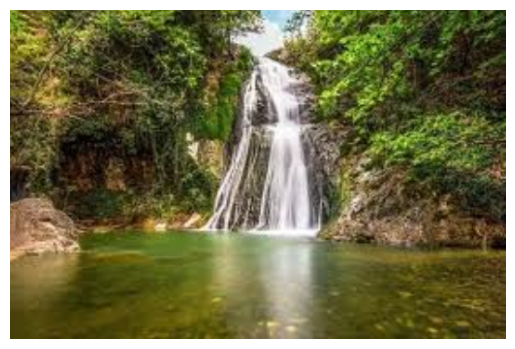

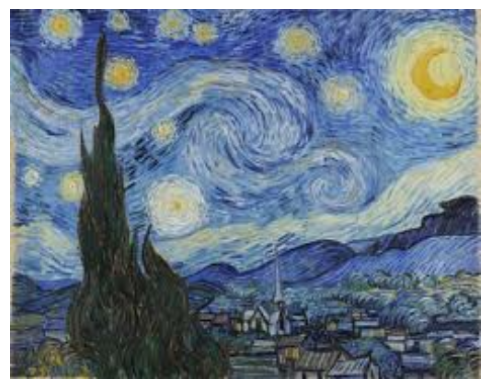

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


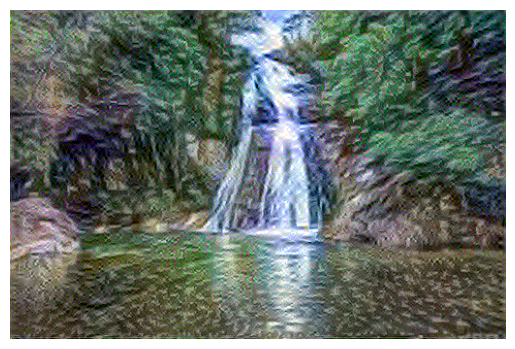

In [ ]:
content = load_image('content.jpg')
show_image(content)
style = load_image('style.jpg')
show_image(style)
stylized_image = StyleTransferrer().transfer(style, content, epochs=1)
show_image(stylized_image)

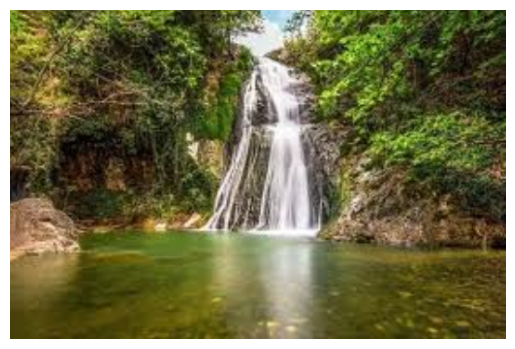

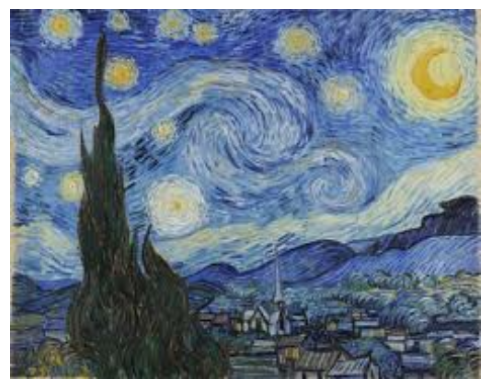

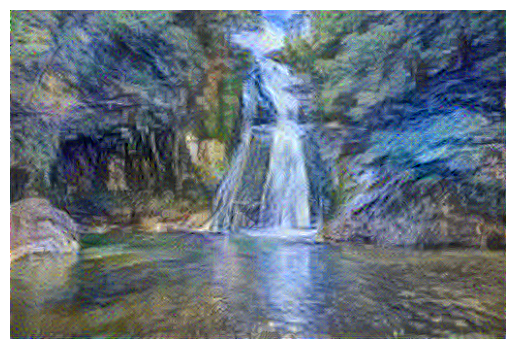

In [ ]:
content = load_image('content.jpg')
show_image(content)
style = load_image('style.jpg')
show_image(style)
stylized_image = StyleTransferrer().transfer(style, content, epochs=10)
show_image(stylized_image)

## Conclusions

The conclusions should justify the impact of:

- the specificity of the image **content**;
- the number of training epochs (e.g., 1, 5, 10)

on the results obtained.

Conclusions

The results show that both the specificity of the image content and the number of training epochs significantly influence the model’s performance.

1. Impact of the specificity of the image content

The specificity of image content plays a crucial role in the learning process. When images contain clear, distinctive, and consistent visual features, the model can extract meaningful patterns more effectively, leading to higher accuracy and better generalization.
Conversely, images with low specificity, high variability, or noise make feature extraction more difficult, which negatively affects the model’s performance. Therefore, datasets with well-defined and discriminative visual characteristics tend to produce more reliable and stable results.

2. Impact of the number of training epochs

The number of training epochs directly affects how well the model learns from the data.

With a small number of epochs (e.g., 1 epoch), the model is undertrained and cannot fully capture the underlying patterns in the data, resulting in low accuracy and poor performance.

With a moderate number of epochs (e.g., 5 epochs), the model learns more representative features, and performance improves significantly.

With a higher number of epochs (e.g., 10 epochs), the model achieves better convergence and higher accuracy, but the risk of overfitting may increase if training continues excessively.

Overall, increasing the number of epochs improves the results up to a certain point, after which the improvement becomes marginal or may even degrade due to overfitting.

General conclusion

The experimental results confirm that both the specificity of image content and the number of training epochs are critical factors in deep learning-based image classification. A well-designed dataset with specific visual features combined with an appropriate number of training epochs leads to optimal model performance.